In [ ]:
# Carbohydrate Transporters exploratatory analyses - processing BLASTp in R

library(data.table) 
setwd("/temporario2/11217468/projects/saureus_global/transporters_blast/blastp_output")
getwd()
carb_transporters_processed <- fread("carb_transporters_processed.tsv", sep = "\t") 
print(head(carb_transporters_processed))

# Due to the large size of this dataframe, I had to perform this step in the server's R (terminal), so this first code box can't be reproduced. 
# A compacted version of "CARB_transp_filt" can be found inside data folder and steps after that can be reproduced


In [ ]:
## Group rows by unique transporters (col 7)
library(dplyr)
allCARB_transp_grouped <- carb_transporters_processed %>%
  group_by(Annotated_Protein)

## Filter out hits with low identity and bad evalues 
CARB_transp_filt <- allCARB_transp_grouped %>%
  filter(E_Value <= 0.001 & Identity > 25 & Bitscore > 50) # Pearson, William R. "An introduction to sequence similarity (“homology”) searching." Current protocols in bioinformatics 42.1 (2013): 3-1. doi:10.1002/0471250953.bi0301s42.

## Removing duplicated hits (i.e. a hit for more than one annotated protein (prokka) in the same genome)	
CARB_transp_filt <- CARB_transp_filt %>%
  distinct(Genome, .keep_all = TRUE)

View(CARB_transp_filt)
write.table(CARB_transp_filt, file = "CARB_transporters_filt.tsv", sep = "\t", row.names = FALSE, col.names = TRUE)


In [2]:
## Make a correspondence between transporter codes and their corresponding carbohydrate 
#codes_path <- "/temporario2/11217468/projects/saureus_global/transporters_blast/blastp_output/transporter_codes/transporters_codes.tsv"
#carb_transporters_codes <- read.table(codes_path, sep = "\t")

carb_transporters_codes <- read.table("data/transporters_codes.tsv", header = TRUE, sep = "\t")
transporters_codes <- as.data.frame(carb_transporters_codes)

library(dplyr)
library(stringr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [ ]:
### Extract codes between bars "|" in Transporter_DB column
CARB_transp_filt$Transporter_DB <- str_extract(CARB_transp_filt$Transporter_DB, "(?<=\\|)[^|]+(?=\\|)") 

### Create a lookup table for transporter codes and their corresponding headers
lookup_table <- transporters_codes %>%
  pivot_longer(cols = everything(), names_to = "Header", values_to = "Code")

### Merge lookup table with CARB_transporters_filt to replace codes with headers
CARB_transporters_mapped <- CARB_transp_filt %>%
  left_join(lookup_table, by = c("Transporter_DB" = "Code"))

### Rename the new column 
CARB_transporters_mapped <- CARB_transporters_mapped %>%
  rename(Sugar = Header) %>%
  mutate(Sugar = if_else(is.na(Sugar), "polysia_transporters", Sugar))

In [ ]:
## Group the dataframe by Transporter and calculate summary statistics
transporter_summary <- CARB_transporters_mapped %>%
  group_by(Sugar) %>%
  summarise(
    Total_Transporters = n_distinct(Annotated_Protein),  # Count unique transporters per genome
    Max_Bitscore = max(Bitscore),                         # Maximum score per genome
    Min_Bitscore = min(Bitscore),                         # Minimum score per genome
    Mean_Bitscore = mean(Bitscore),                       # Mean score per genome
    Median_Bitscore = median(Bitscore),                    # Median score per genome
    Max_E_Value = max(E_Value),                     # Maximum E_Value per genome
    Min_E_Value = min(E_Value),                     # Minimum E_Value per genome
    Mean_E_Value = mean(E_Value),                   # Mean E_Value per genome
    Median_E_Value = median(E_Value),               # Median E_Value per genome
    Max_Identity = max(Identity),                     # Maximum E_Value per genome
    Min_Identity = min(Identity),                     # Minimum E_Value per genome
    Mean_Identity = mean(Identity),                   # Mean E_Value per genome
    Median_Identity = median(Identity),               # Median E_Value per genome
    Max_Length = max(Length),                   # Maximum Coverage per genome
    Min_Length = min(Length),                   # Minimum Coverage per genome
    Mean_Length = mean(Length),                 # Mean Coverage per genome
    Median_Length = median(Length)              # Median Coverage per genome
  ) %>%
  ungroup()  # Remove grouping for further operations

View(transporter_summary)
write.table(transporter_summary, file = "carb_transporter_summary.tsv", sep = "\t", row.names = FALSE, col.names = TRUE)

## Group the dataframe by Genome and calculate summary statistics
genome_summary <- CARB_transporters_mapped %>%
  group_by(Genome) %>%
  summarise(
    Total_Transporters = n_distinct(Annotated_Protein),  # Count unique transporters per genome
    Max_Bitscore = max(Bitscore),                         # Maximum score per genome
    Min_Bitscore = min(Bitscore),                         # Minimum score per genome
    Mean_Bitscore = mean(Bitscore),                       # Mean score per genome
    Median_Bitscore = median(Bitscore),                    # Median score per genome
    Max_E_Value = max(E_Value),                     # Maximum E_Value per genome
    Min_E_Value = min(E_Value),                     # Minimum E_Value per genome
    Mean_E_Value = mean(E_Value),                   # Mean E_Value per genome
    Median_E_Value = median(E_Value),               # Median E_Value per genome
    Max_Identity = max(Identity),                     # Maximum E_Value per genome
    Min_Identity = min(Identity),                     # Minimum E_Value per genome
    Mean_Identity = mean(Identity),                   # Mean E_Value per genome
    Median_Identity = median(Identity),               # Median E_Value per genome
    Max_Length = max(Length),                   # Maximum Coverage per genome
    Min_Length = min(Length),                   # Minimum Coverage per genome
    Mean_Length = mean(Length),                 # Mean Coverage per genome
    Median_Length = median(Length)              # Median Coverage per genome
  ) %>%
  ungroup()  # Remove grouping for further operations

View(genome_summary)

write.table(genome_summary, file = "genome_summary_CARBtransp.tsv", sep = "\t", row.names = FALSE, col.names = TRUE)

In [ ]:
## Combining b_lactams table with the transporters summary 

### Remove suffix and rename columns
abricate_blactams$FILE <- gsub("_genomic-ARGs.txt", "", abricate_blactams$FILE)
names(abricate_blactams)[1] <- "Genome"
names(abricate_blactams)[2] <- "Total_ARGs"

### Merge dfs 
carbs_ARGs_df <- merge(abricate_blactams, genome_summary, by = "Genome", all.x = FALSE)
View(carbs_ARGs_df)

### Replace coverage values for blaZ and mec genes with hits count
count_semicolons <- function(x) {
  ifelse(x == 0, 0, nchar(x) - nchar(gsub(";", "", x)) + 1)
} # Create a function to count semicolons in each element of a column
carbs_ARGs_df <- carbs_ARGs_df %>%
  mutate(
    blaZ = count_semicolons(blaZ),
    mecA = count_semicolons(mecA),
    mecC = count_semicolons(mecC)
  ) # Replace values in columns 3, 4, and 5 based on the condition
 
carbs_ARGs_df$Total_Transporters[is.na(carbs_ARGs_df$Total_Transporters)] <- 0 # replace NAs with 0


In [ ]:
## Combining b_lactams table with the CARB_transporters_mapped df
full_carbs_ARGs_df <- merge(abricate_blactams, CARB_transporters_mapped, by = "Genome", all.x = TRUE) 

### Replace coverage values for blaZ and mec genes with hits count
count_semicolons <- function(x) {
  ifelse(x == 0, 0, nchar(x) - nchar(gsub(";", "", x)) + 1)
} # Create a function to count semicolons in each element of a column
full_carbs_ARGs_df <- full_carbs_ARGs_df %>%
  mutate(
    blaZ = count_semicolons(blaZ),
    mecA = count_semicolons(mecA),
    mecC = count_semicolons(mecC)
  ) # Replace values in columns 3, 4, and 5 based on the condition
View(full_carbs_ARGs_df)

In [5]:
# -------------- BELOW THIS YOU CAN BEGIN TO REPRODUCE AGAIN WITH THE COMPACTED FILE IN DATA FOLDER
full_carbs_ARGs_df <- read.table("data/full_carbs_ARGs_df.tsv", header = TRUE, sep = "\t")
carbs_ARGs_df <- read.table("data/carbs_ARGs_df.tsv", header = TRUE, sep = "\t")
## Group by Genome and Sugar, and count the occurrences
grouped_df <- full_carbs_ARGs_df %>%
  group_by(Genome, Sugar, Category) %>%
  summarise(Transporter_Count = n())
  
grouped_df2 <- grouped_df %>%
  group_by(Genome, Category) %>%
  summarise(Total_Transporter_Count = sum(Transporter_Count, na.rm = TRUE))
View(grouped_df2)

grouped_df2 <- grouped_df2 %>%
  left_join(carbs_ARGs_df %>% select(Genome, Total_ARGs), by = "Genome")
View(grouped_df2)

write.table(full_carbs_ARGs_df, file = "full_carbs_ARGs_df.tsv", sep = "\t", row.names = FALSE, col.names = TRUE)
write.table(grouped_df, file = "grouped_df.tsv", sep = "\t", row.names = FALSE, col.names = TRUE)
#write.table(grouped_df3, file = "grouped_df2.tsv", sep = "\t", row.names = FALSE, col.names = TRUE)

`summarise()` has grouped output by 'Genome', 'Sugar'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Genome'. You can override using the `.groups` argument.


Genome,Category,Total_Transporter_Count
<chr>,<chr>,<int>
GCA_000009665.1_ASM966v1,MRSA,137
GCA_000010465.1_ASM1046v1,MSSA,131
GCA_000011265.1_ASM1126v1,MRSA,134
GCA_000011505.1_ASM1150v1,MRSA,142
GCA_000011525.1_ASM1152v1,MRSA,135
GCA_000013425.1_ASM1342v1,MSSA,132
GCA_000016805.1_ASM1680v1,MRSA,136
GCA_000017085.1_ASM1708v1,MRSA,137
GCA_000027045.1_ASM2704v1,MRSA,133


Genome,Category,Total_Transporter_Count,Total_ARGs
<chr>,<chr>,<int>,<int>
GCA_000009665.1_ASM966v1,MRSA,137,17
GCA_000010465.1_ASM1046v1,MSSA,131,9
GCA_000011265.1_ASM1126v1,MRSA,134,9
GCA_000011505.1_ASM1150v1,MRSA,142,15
GCA_000011525.1_ASM1152v1,MRSA,135,10
GCA_000013425.1_ASM1342v1,MSSA,132,9
GCA_000016805.1_ASM1680v1,MRSA,136,15
GCA_000017085.1_ASM1708v1,MRSA,137,15
GCA_000027045.1_ASM2704v1,MRSA,133,20


Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as of ggplot2 3.3.4.”


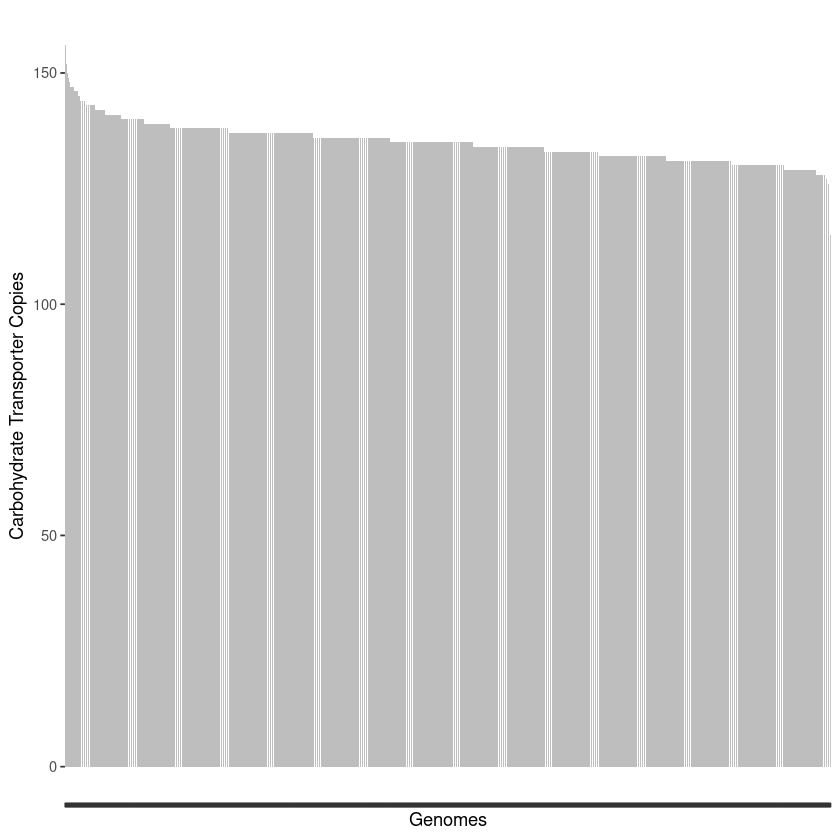

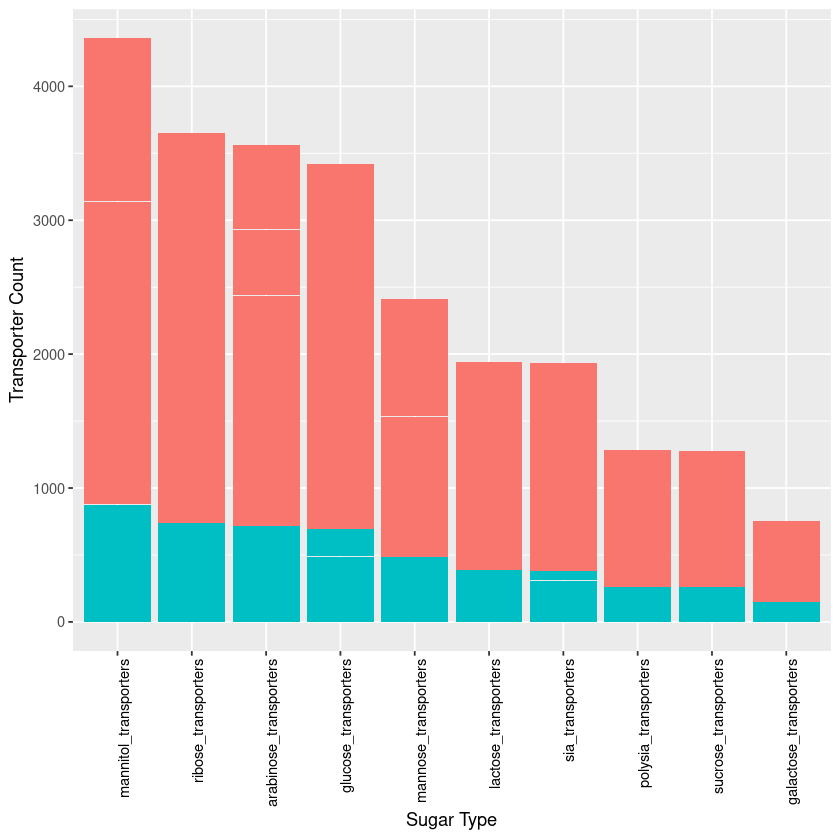

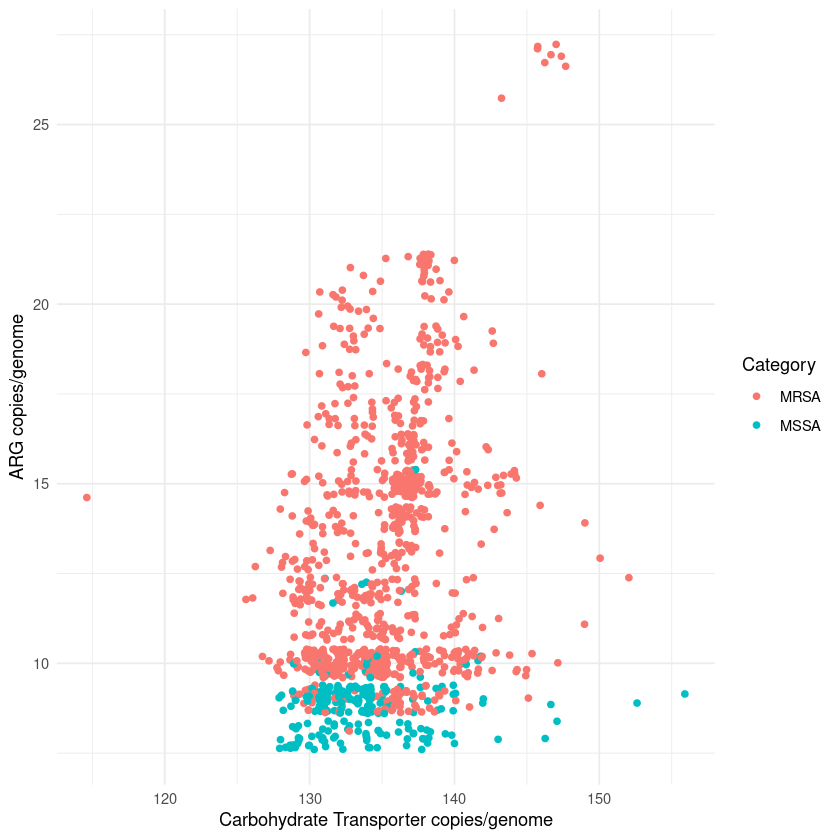

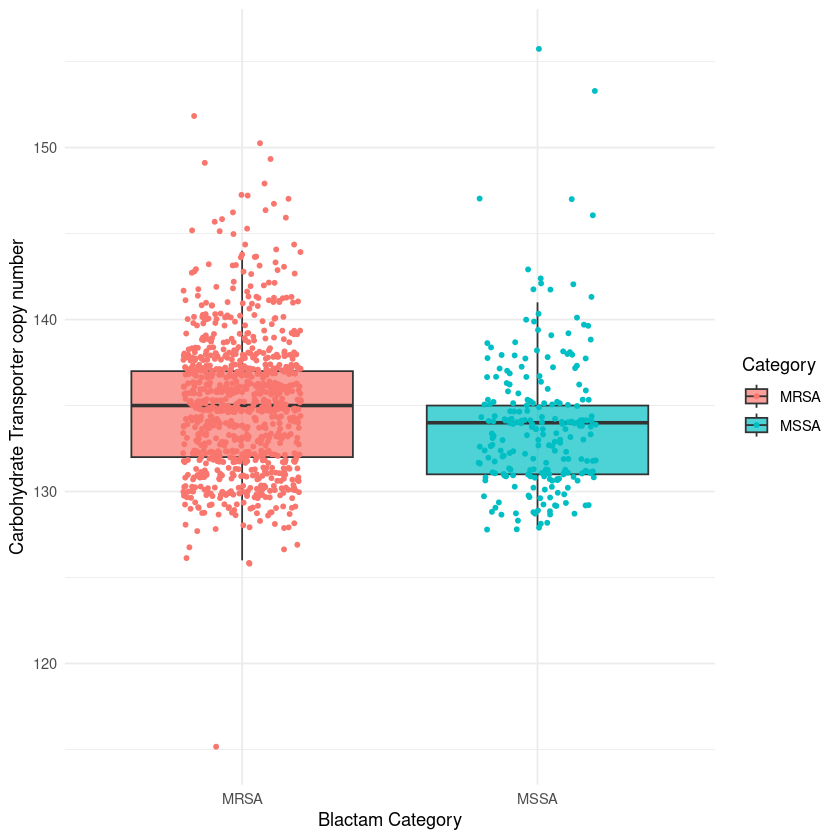

In [6]:
## Check the distribution of your data
library(ggplot2)
library(ggsignif)
library(dplyr)
 
### Histogram with Transporter copy numbers in genomes
transp_distribution <- ggplot(grouped_df2, aes(x = reorder(Genome, -Total_Transporter_Count), y = Total_Transporter_Count)) +
  geom_bar(stat = "identity", fill = "gray") +
  labs(x = "Genomes", y = "Carbohydrate Transporter Copies") +
  theme(axis.text.x = element_blank())  # Remove x-axis labels for better readability
transp_distribution

### Histogram with Transporter Count by sugar type in MRSA and MSSA
ggplot(grouped_df, aes(x = reorder(Sugar, -Transporter_Count), y = log(Transporter_Count), fill = Category)) +
    geom_bar(stat = "identity") +
    labs(x = "Sugar Type",
         y = "Transporter Count") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, color = "black")) +
    guides(fill = FALSE)  # Removes the legend for fill aesthetic

### Scatter plot ARG x Transporters
ggplot(grouped_df2, aes(x = Total_Transporter_Count, y = Total_ARGs, color = Category)) +
  geom_point(position = "jitter") +
  labs(x = "Carbohydrate Transporter copies/genome", y = "ARG copies/genome", color = "Category") +
  theme_minimal()   
  
### Make a box plot by b-lactam resistance category
transporter_boxplot <- ggplot(grouped_df2, aes(x = Category, y = Total_Transporter_Count, fill = Category)) +
  geom_boxplot(alpha = 0.7, outlier.shape = NA) +  # Draw box plot
  geom_jitter(width = 0.2, size = 1.0, aes(color = Category)) +  # Add jittered dots
  labs(x = "Blactam Category", y = "Carbohydrate Transporter copy number") +
  theme_minimal()
transporter_boxplot


Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact confidence intervals with ties”



	Wilcoxon rank sum test with continuity correction

data:  Total_Transporter_Count by Category
W = 133360, p-value = 2.453e-08
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 1.000017 2.000064
sample estimates:
difference in location 
              1.999974 


Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact confidence intervals with ties”



	Wilcoxon rank sum test with continuity correction

data:  Transporter_Count by Category
W = 117540, p-value = 0.02918
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 6.533734e-05 4.505734e-05
sample estimates:
difference in location 
          5.671413e-05 


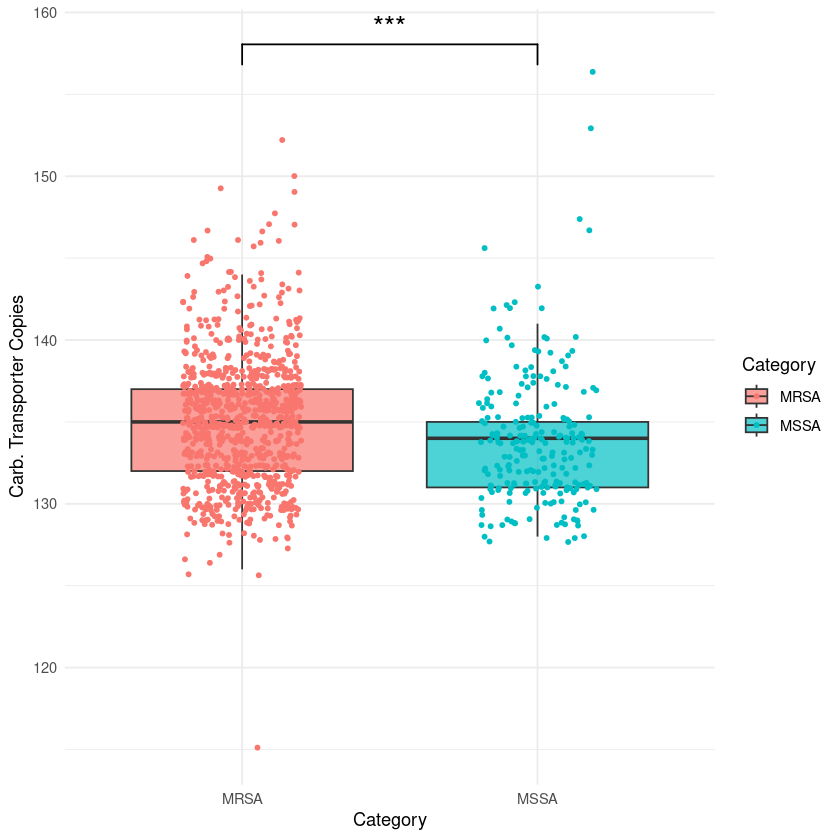

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact confidence intervals with ties”



	Wilcoxon rank sum test with continuity correction

data:  Transporter_Count by Category
W = 129172, p-value = 3.589e-08
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 1.602656e-05 1.518874e-05
sample estimates:
difference in location 
          4.227767e-05 


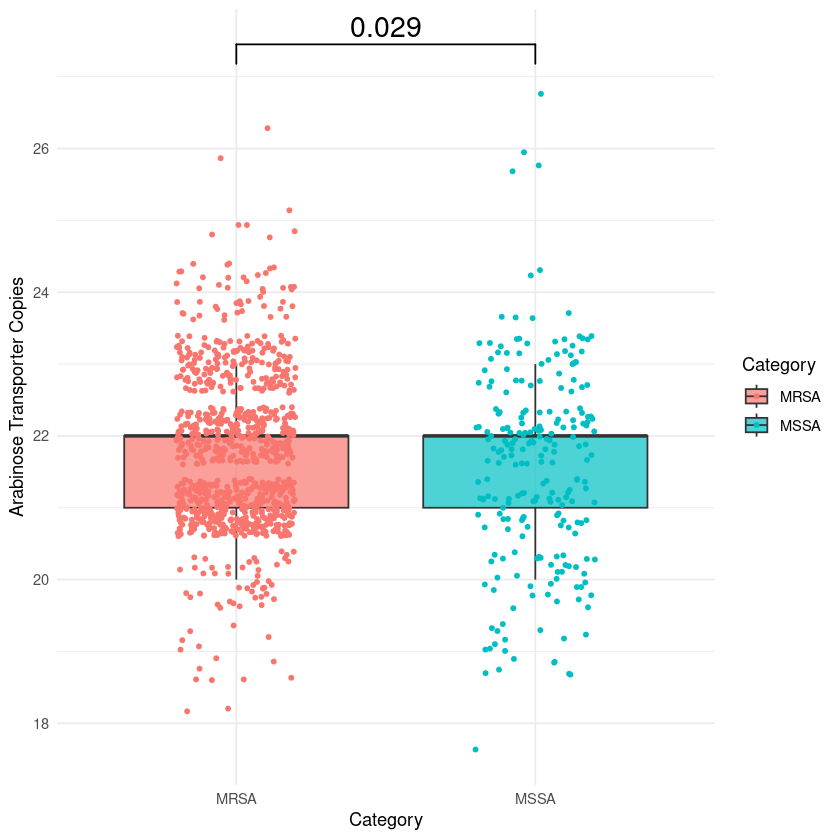

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact confidence intervals with ties”



	Wilcoxon rank sum test with continuity correction

data:  Transporter_Count by Category
W = 120170, p-value = 0.005939
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 2.790275e-05 7.575369e-05
sample estimates:
difference in location 
          7.174655e-05 


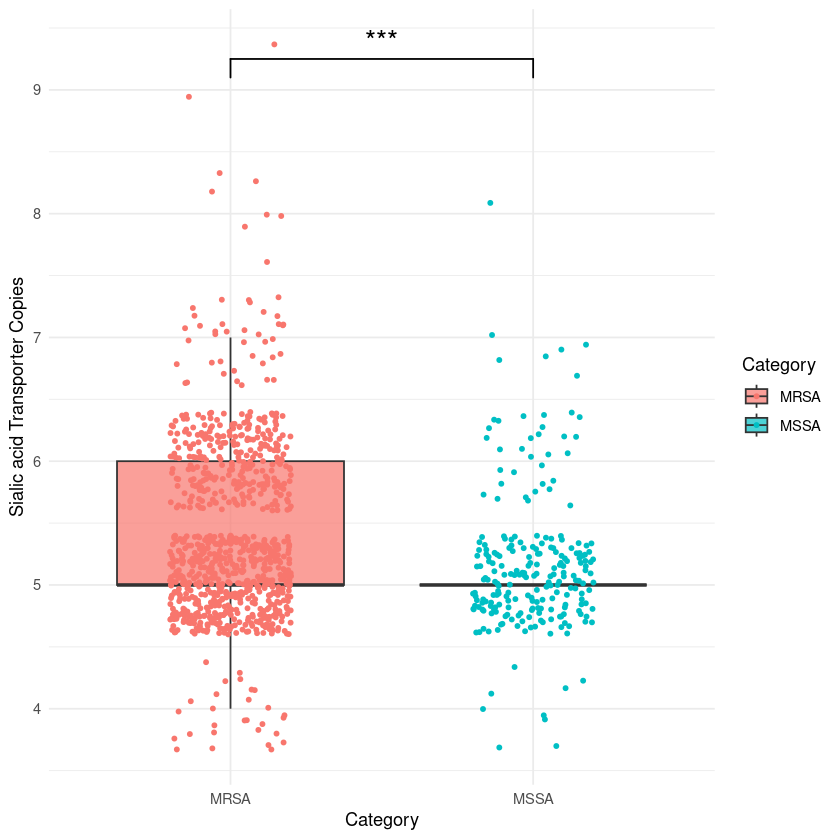

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact confidence intervals with ties”



	Wilcoxon rank sum test with continuity correction

data:  Transporter_Count by Category
W = 110352, p-value = 0.1606
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 -7.522039e-05  4.373916e-06
sample estimates:
difference in location 
          4.179506e-05 


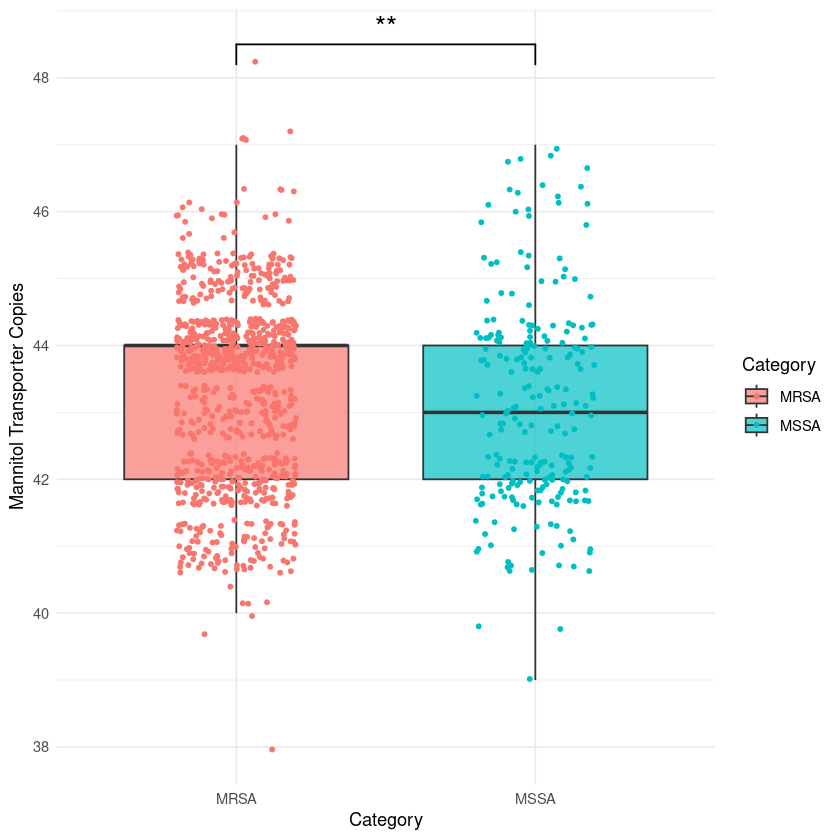

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact confidence intervals with ties”



	Wilcoxon rank sum test with continuity correction

data:  Transporter_Count by Category
W = 112826, p-value = 0.006195
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 -7.444961e-05  5.228018e-05
sample estimates:
difference in location 
          3.473272e-05 


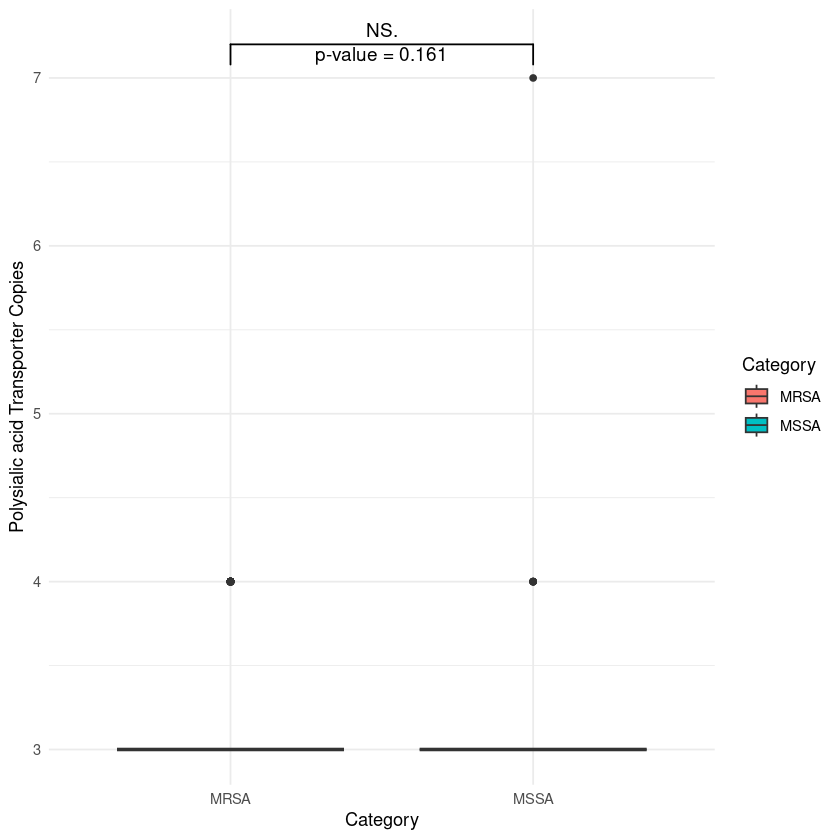

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact confidence intervals with ties”



	Wilcoxon rank sum test with continuity correction

data:  Transporter_Count by Category
W = 107892, p-value = 0.9541
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 -7.993303e-05  2.373064e-05
sample estimates:
difference in location 
         -4.032304e-06 


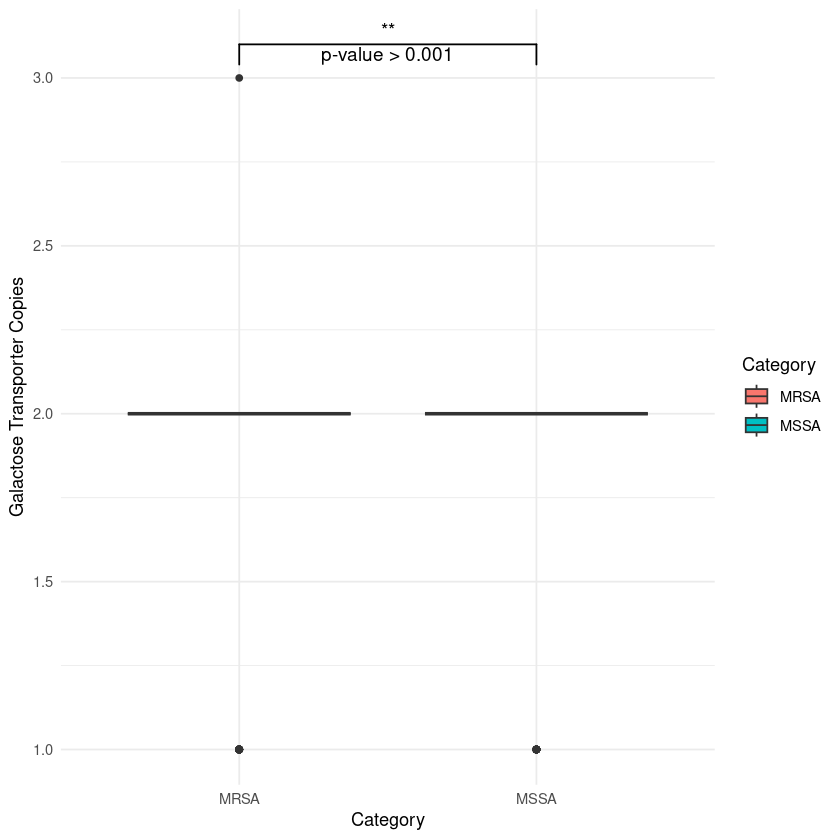

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact confidence intervals with ties”



	Wilcoxon rank sum test with continuity correction

data:  Transporter_Count by Category
W = 109246, p-value = 0.7497
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 -2.777387e-05  3.076857e-07
sample estimates:
difference in location 
          1.314894e-06 


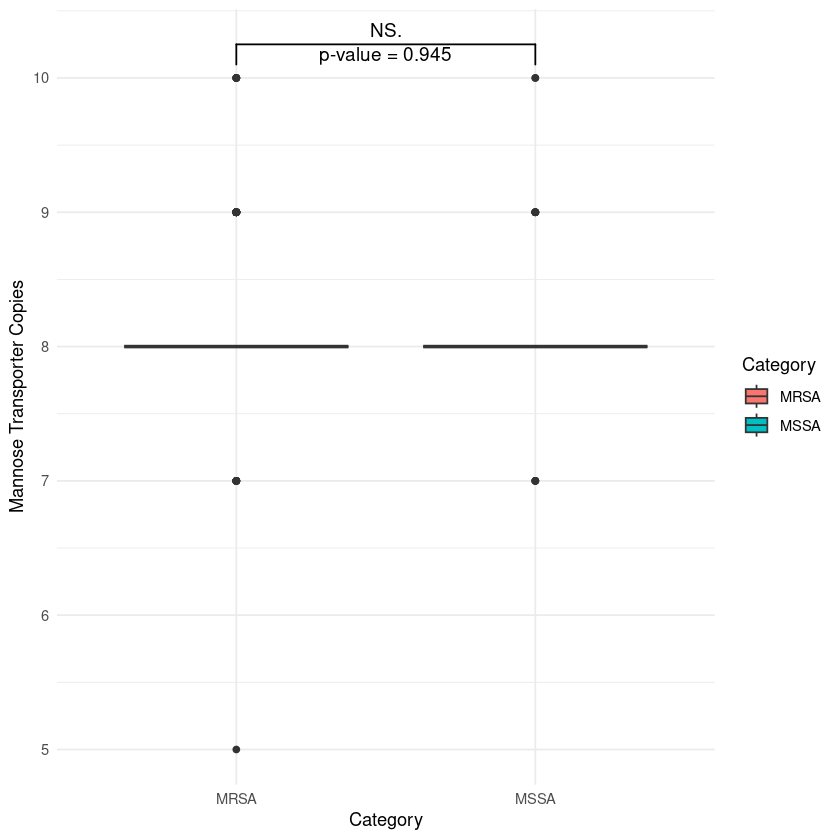

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact confidence intervals with ties”



	Wilcoxon rank sum test with continuity correction

data:  Transporter_Count by Category
W = 108362, p-value = 0.7873
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 -5.904733e-05  5.947456e-05
sample estimates:
difference in location 
          2.366592e-05 


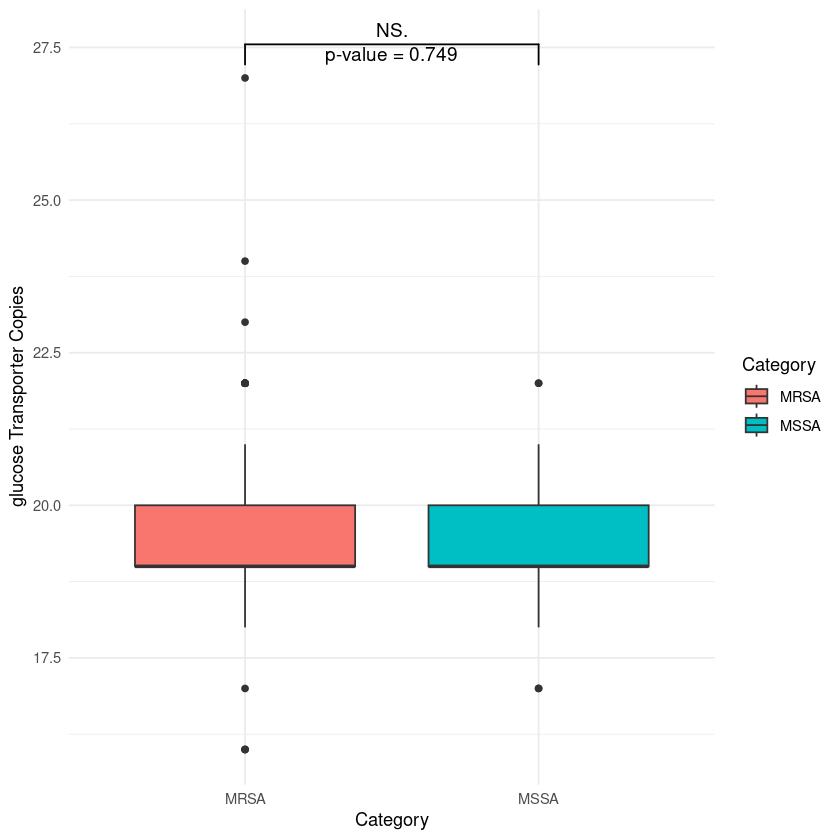

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact confidence intervals with ties”



	Wilcoxon rank sum test with continuity correction

data:  Transporter_Count by Category
W = 124464, p-value = 0.0001783
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 2.766172e-05 2.888186e-05
sample estimates:
difference in location 
          1.884965e-05 


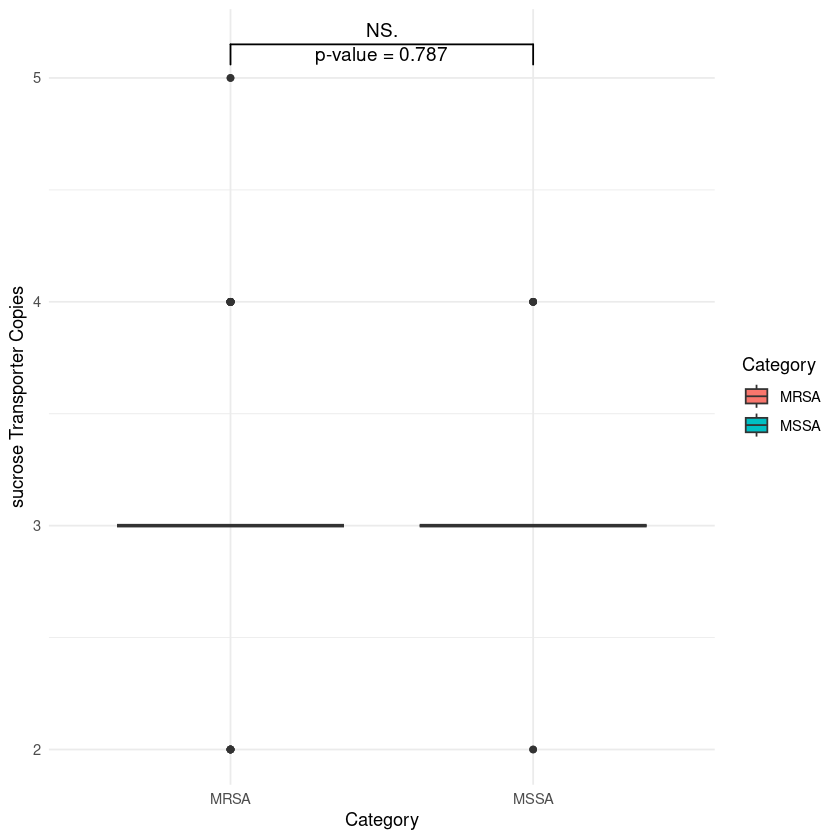

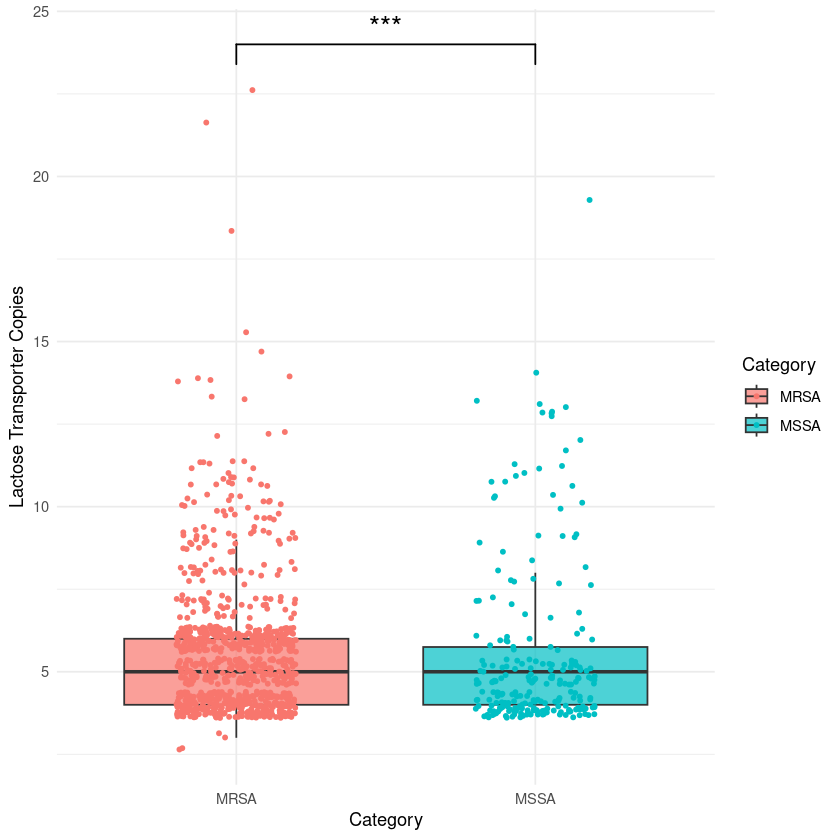

In [7]:
## Check for statiscal difference 
wilcox_carb1 <- wilcox.test(Total_Transporter_Count ~ Category, data = grouped_df2,
                             exact = TRUE, correct = TRUE, 
                             p.adjust.method = "bonferroni", 
                             conf.int = TRUE, conf.level = 0.95)
wilcox_carb1 # W = 133360, p-value = 2.453e-08; 95% CI: 1.000017 2.000064
p_value_carb1 = 2.453e-08

ggplot(grouped_df2, aes(x = Category, y = Total_Transporter_Count, fill = Category)) +
  geom_boxplot(alpha = 0.7, outlier.shape = NA) +  # Draw box plot
  geom_jitter(width = 0.2, size = 1.0, aes(color = Category)) +  # Add jittered dots
  labs(x = "Category", y = "Carb. Transporter Copies") +
  theme_minimal() +
  # Add significance annotation
  geom_signif(comparisons = list(c("MRSA", "MSSA")), 
              textsize = 6, 
              map_signif_level = TRUE) 


## Subset df and repeat this for each unique sugar transporter 
arabinose_ARGs <- grouped_df %>% filter(Sugar == "arabinose_transporters")
mannitol_ARGs <- grouped_df %>% filter(Sugar == "mannitol_transporters")
sia_ARGs <- grouped_df %>% filter(Sugar == "sia_transporters")
polysia_ARGs <- grouped_df %>% filter(Sugar == "polysia_transporters")
galactose_ARGs <- grouped_df %>% filter(Sugar == "galactose_transporters")
mannose_ARGs <- grouped_df %>% filter(Sugar == "mannose_transporters")
sucrose_ARGs <- grouped_df %>% filter(Sugar == "sucrose_transporters")
glucose_ARGs <- grouped_df %>% filter(Sugar == "glucose_transporters")
lactose_ARGs <- grouped_df %>% filter(Sugar == "lactose_transporters")
ribose_ARGs <- grouped_df %>% filter(Sugar == "ribose_transporters")

arabinose_wilcox <- wilcox.test(Transporter_Count ~ Category, data = arabinose_ARGs,
                             exact = TRUE, correct = TRUE, 
                             p.adjust.method = "bonferroni", 
                             conf.int = TRUE, conf.level = 0.95)
arabinose_wilcox # W = 117540, p-value = 0.02918; 95% CI: 6.533734e-05 4.505734e-05

arabinose_boxplot <- ggplot(arabinose_ARGs, aes(x = Category, y = Transporter_Count, fill = Category)) +
  geom_boxplot(alpha = 0.7, outlier.shape = NA) +  # Draw box plot
  geom_jitter(width = 0.2, size = 1.0, aes(color = Category)) +  # Add jittered dots
  labs(x = "Category", y = "Arabinose Transporter Copies") +
  theme_minimal() +
  scale_y_continuous(breaks = scales::pretty_breaks(n = 6)) +
  # Add significance annotation
  geom_signif(comparisons = list(c("MRSA", "MSSA")), 
              textsize = 6, 
              map_signif_level = FALSE)
arabinose_boxplot

sia_wilcox <- wilcox.test(Transporter_Count ~ Category, data = sia_ARGs,
                             exact = TRUE, correct = TRUE, 
                             p.adjust.method = "bonferroni", 
                             conf.int = TRUE, conf.level = 0.95)
sia_wilcox # W = 129172, p-value = 3.589e-08; 95% CI: 1.602656e-05 1.518874e-05

sia_boxplot <- ggplot(sia_ARGs, aes(x = Category, y = Transporter_Count, fill = Category)) +
  geom_boxplot(alpha = 0.7, outlier.shape = NA) +  # Draw box plot
  geom_jitter(width = 0.2, size = 1.0, aes(color = Category)) +  # Add jittered dots
  labs(x = "Category", y = "Sialic acid Transporter Copies") +
  theme_minimal() +
  scale_y_continuous(breaks = scales::pretty_breaks(n = 8)) +
  # Add significance annotation
  geom_signif(comparisons = list(c("MRSA", "MSSA")), 
              textsize = 6, 
              map_signif_level = TRUE)
sia_boxplot

mannitol_wilcox <- wilcox.test(Transporter_Count ~ Category, data = mannitol_ARGs,
                             exact = TRUE, correct = TRUE, 
                             p.adjust.method = "bonferroni", 
                             conf.int = TRUE, conf.level = 0.95)
mannitol_wilcox # W = 120170, p-value = 0.005939; 95% CI: 2.790275e-05 7.575369e-05

mannitol_boxplot <- ggplot(mannitol_ARGs, aes(x = Category, y = Transporter_Count, fill = Category)) +
  geom_boxplot(alpha = 0.7, outlier.shape = NA) +  # Draw box plot
  geom_jitter(width = 0.2, size = 1.0, aes(color = Category)) +  # Add jittered dots
  labs(x = "Category", y = "Mannitol Transporter Copies") +
  theme_minimal() +
  scale_y_continuous(breaks = scales::pretty_breaks(n = 6)) +
  # Add significance annotation
  geom_signif(comparisons = list(c("MRSA", "MSSA")), 
              textsize = 6, 
              map_signif_level = TRUE)
mannitol_boxplot

polysia_wilcox <- wilcox.test(Transporter_Count ~ Category, data = polysia_ARGs,
                             exact = TRUE, correct = TRUE, 
                             p.adjust.method = "bonferroni", 
                             conf.int = TRUE, conf.level = 0.95)
polysia_wilcox # W = 110352, p-value = 0.1606; 95% CI: -7.522039e-05  4.373916e-06

polysia_boxplot <- ggplot(polysia_ARGs, aes(x = Category, y = Transporter_Count, fill = Category)) +
  geom_boxplot() +
  labs(x = "Category", y = "Polysialic acid Transporter Copies") +
  theme_minimal() +
  # Add significance annotation
  geom_signif(comparisons = list(c("MRSA", "MSSA")), 
              textsize = 4, 
              map_signif_level = TRUE) +
  # Add p-value annotation
  annotate("text", x = 1.5, y = max(polysia_ARGs$Transporter_Count), 
           label = paste("p-value = 0.161"), 
           hjust = 0.5, vjust = -1.2, size = 4)
polysia_boxplot

galactose_wilcox <- wilcox.test(Transporter_Count ~ Category, data = galactose_ARGs,
                             exact = TRUE, correct = TRUE, 
                             p.adjust.method = "bonferroni", 
                             conf.int = TRUE, conf.level = 0.95)
galactose_wilcox # W = 112826, p-value = 0.006195; 95% CI:  -7.444961e-05  5.228018e-05

galactose_boxplot <- ggplot(galactose_ARGs, aes(x = Category, y = Transporter_Count, fill = Category)) +
  geom_boxplot() +
  labs(x = "Category", y = "Galactose Transporter Copies") +
  theme_minimal() +
  # Add significance annotation
  geom_signif(comparisons = list(c("MRSA", "MSSA")), 
              textsize = 4, 
              map_signif_level = TRUE) +
  # Add p-value annotation
  annotate("text", x = 1.5, y = max(galactose_ARGs$Transporter_Count), 
           label = paste("p-value > 0.001"), 
           hjust = 0.5, vjust = -1.2, size = 4)
galactose_boxplot

mannose_wilcox <- wilcox.test(Transporter_Count ~ Category, data = mannose_ARGs,
                             exact = TRUE, correct = TRUE, 
                             p.adjust.method = "bonferroni", 
                             conf.int = TRUE, conf.level = 0.95)
mannose_wilcox # W = 107892, p-value = 0.9541; 95% CI:  -7.993303e-05  2.373064e-05

mannose_boxplot <- ggplot(mannose_ARGs, aes(x = Category, y = Transporter_Count, fill = Category)) +
  geom_boxplot() +
  labs(x = "Category", y = "Mannose Transporter Copies") +
  theme_minimal() +
  # Add significance annotation
  geom_signif(comparisons = list(c("MRSA", "MSSA")), 
              textsize = 4, 
              map_signif_level = TRUE) +
  # Add p-value annotation
  annotate("text", x = 1.5, y = max(mannose_ARGs$Transporter_Count), 
           label = paste("p-value = 0.945"), 
           hjust = 0.5, vjust = -1.2, size = 4)
mannose_boxplot

glucose_wilcox <- wilcox.test(Transporter_Count ~ Category, data = glucose_ARGs,
                             exact = TRUE, correct = TRUE, 
                             p.adjust.method = "bonferroni", 
                             conf.int = TRUE, conf.level = 0.95)
glucose_wilcox #W = 109246, p-value = 0.7497; 95% CI:  -2.777387e-05  3.076857e-07

glucose_boxplot <- ggplot(glucose_ARGs, aes(x = Category, y = Transporter_Count, fill = Category)) +
  geom_boxplot() +
  labs(x = "Category", y = "glucose Transporter Copies") +
  theme_minimal() +
  # Add significance annotation
  geom_signif(comparisons = list(c("MRSA", "MSSA")), 
              textsize = 4, 
              map_signif_level = TRUE) +
  # Add p-value annotation
  annotate("text", x = 1.5, y = max(glucose_ARGs$Transporter_Count), 
           label = paste("p-value = 0.749"), 
           hjust = 0.5, vjust = -1.2, size = 4)
glucose_boxplot

sucrose_wilcox <- wilcox.test(Transporter_Count ~ Category, data = sucrose_ARGs,
                             exact = TRUE, correct = TRUE, 
                             p.adjust.method = "bonferroni", 
                             conf.int = TRUE, conf.level = 0.95)
sucrose_wilcox # W = 108362, p-value = 0.7873; 95% CI:   -5.904733e-05  5.947456e-05

sucrose_boxplot <- ggplot(sucrose_ARGs, aes(x = Category, y = Transporter_Count, fill = Category)) +
  geom_boxplot() +
  labs(x = "Category", y = "sucrose Transporter Copies") +
  theme_minimal() +
  # Add significance annotation
  geom_signif(comparisons = list(c("MRSA", "MSSA")), 
              textsize = 4, 
              map_signif_level = TRUE) +
  # Add p-value annotation
  annotate("text", x = 1.5, y = max(sucrose_ARGs$Transporter_Count), 
           label = paste("p-value = 0.787"), 
           hjust = 0.5, vjust = -1.2, size = 4)
sucrose_boxplot

lactose_wilcox <- wilcox.test(Transporter_Count ~ Category, data = lactose_ARGs,
                             exact = TRUE, correct = TRUE, 
                             p.adjust.method = "bonferroni", 
                             conf.int = TRUE, conf.level = 0.95)
lactose_wilcox # W = 124464, p-value = 0.0001783; 95% CI:    2.766172e-05 2.888186e-05

lactose_boxplot <- ggplot(lactose_ARGs, aes(x = Category, y = Transporter_Count, fill = Category)) +
  geom_boxplot(alpha = 0.7, outlier.shape = NA) +  # Draw box plot
  geom_jitter(width = 0.2, size = 1.0, aes(color = Category)) +  # Add jittered dots
  labs(x = "Category", y = "Lactose Transporter Copies") +
  theme_minimal() +
  scale_y_continuous(breaks = scales::pretty_breaks(n = 4)) +
   # Add significance annotation
  geom_signif(comparisons = list(c("MRSA", "MSSA")), 
              textsize = 6, 
              map_signif_level = TRUE) 
lactose_boxplot

Warning message in cor.test.default(carbs_ARGs_df$Total_Transporters, carbs_ARGs_df$Total_ARGs, :
“Cannot compute exact p-value with ties”
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


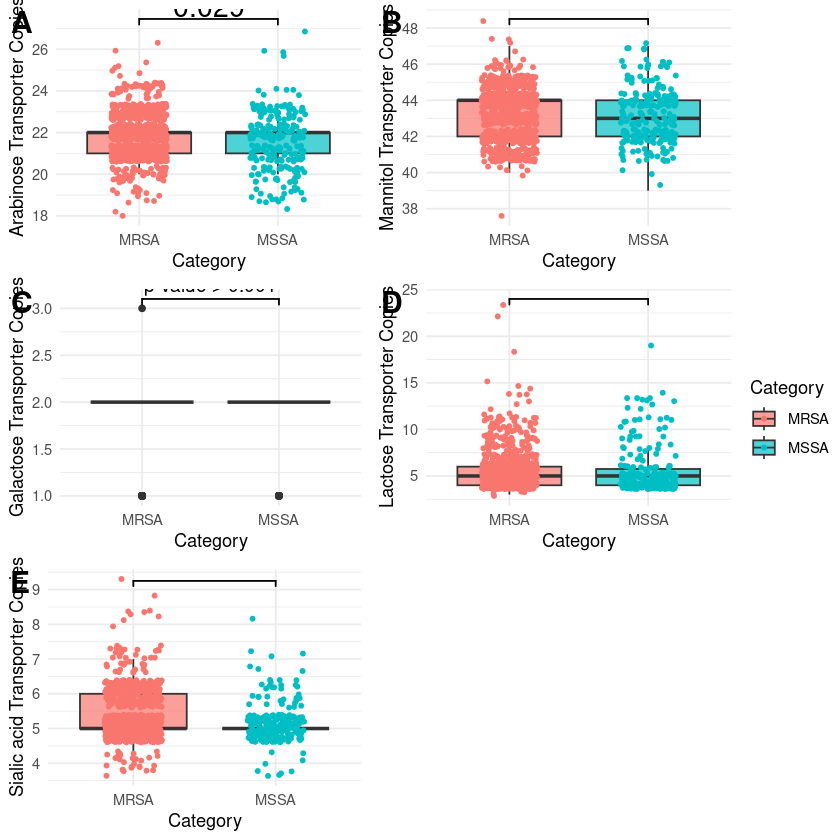

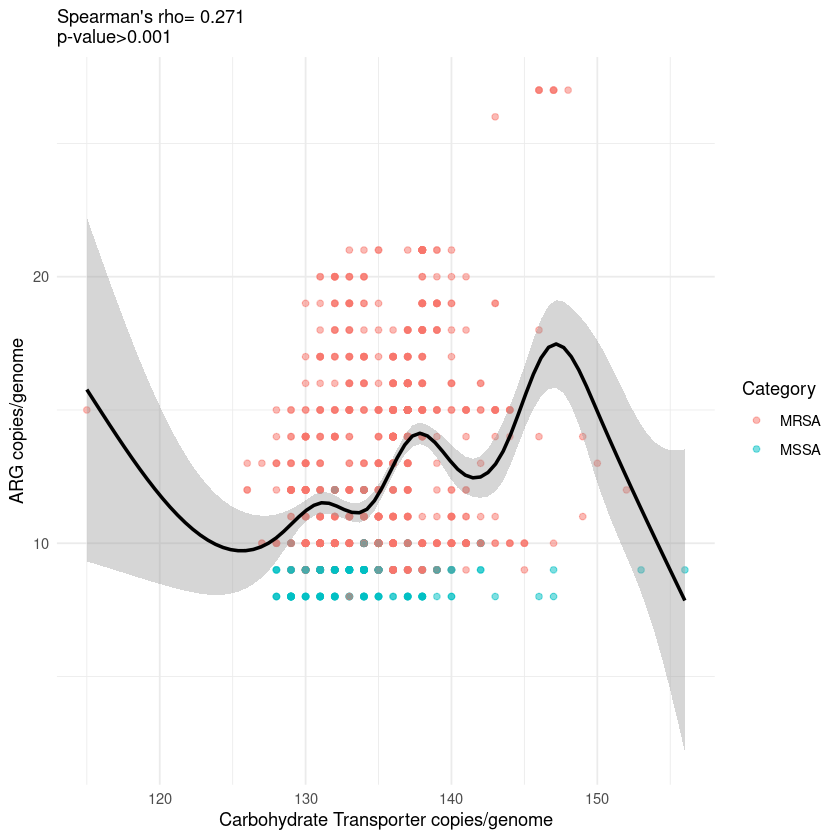

In [8]:
## Plotting all sugars with p < 0.05

library(ggpubr)
ggarrange(arabinose_boxplot, mannitol_boxplot, galactose_boxplot, lactose_boxplot, sia_boxplot,
          labels = c("A", "B", "C", "D", "E"),
          font.label = list(size = 18),
          ncol = 2, nrow = 3,
          legend = "right", 
          common.legend = TRUE)

write.table(carbs_ARGs_df, file = "carbs_ARGs_df.tsv", sep = "\t", row.names = FALSE, col.names = TRUE)
write.table(full_carbs_ARGs_df, file = "carbs_ARGs_df.tsv", sep = "\t", row.names = FALSE, col.names = TRUE)

# Spearman rank correlation test and visualization 
cor_ARG_transporters <- cor.test(carbs_ARGs_df$Total_Transporters, carbs_ARGs_df$Total_ARGs, method = "spearman") # S = 188171246, p-value < 2.2e-16; rho 0.2710382

ggplot(carbs_ARGs_df, aes(x = Total_Transporters, y = Total_ARGs, color = Category)) +
  geom_point(alpha = 0.5) +
  geom_smooth(method = "auto", se = TRUE, color = "black", linetype = "solid") + # `geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
  labs(x = "Carbohydrate Transporter copies/genome", y = "ARG copies/genome", color = "Category", 
  subtitle = paste("Spearman's rho=", round(cor_ARG_transporters$estimate, 3),
  "\np-value>0.001")) +
  theme_minimal()   


In [12]:
# Spearman rank correlation test: carbohydrate transporters x efflux ARGs
library(tidyr)
library(dplyr)

## Create a wide-format data frame for transporters
transporters_wide <- full_carbs_ARGs_df %>%
  group_by(Genome, Sugar) %>%
  summarise(Transporter_Count = n(), .groups = "drop") %>%
  pivot_wider(names_from = Sugar, values_from = Transporter_Count, values_fill = list(Transporter_Count = 0))

## Import efflux_blactam_ARGs.tsv into R (made from ABRICATE output)
View(efflux_blactam_ARGs)

## Merge efflux_blactam_ARGs df + transporters_wide 
cor_ARG_transp_full <- transporters_wide %>%
  left_join(efflux_ARGsWblactam, by = "Genome")
  
write.table(cor_ARG_transp_full, file = "cor_ARG_transp_full.tsv", sep = "\t", row.names = FALSE, col.names = TRUE)

## Create a matrix to perform Spearman's correlation test 
arg_names <- colnames(cor_ARG_transp_full)[grepl("^(norA|lmrS|arl|mep|mgrA|qac|tet|fexA|blaZ|mec)$", colnames(cor_ARG_transp_full))]
transporter_names <- colnames(cor_ARG_transp_full)[grepl("_transporters$", colnames(cor_ARG_transp_full))] # Extract the names of ARGs and transporters

correlation_matrix <- matrix(NA, nrow = length(arg_names), ncol = length(transporter_names),
                             dimnames = list(arg_names, transporter_names)) # Initialize an empty matrix to store the correlation coefficients

## Calculate the Spearman correlation for each pair of ARG and transporter
for (arg in arg_names) {
  for (transporter in transporter_names) {
    correlation_test <- cor.test(cor_ARG_transp_full[[arg]], cor_ARG_transp_full[[transporter]], method = "spearman")
    correlation_matrix[arg, transporter] <- correlation_test$estimate
  }
}

View(correlation_matrix)

correlation_matrix[is.na(correlation_matrix)] <- 0 # replacing NAs with zeros 

#correlation_matrix <- correlation_matrix[rowSums(correlation_matrix) != 0, ]

write.table(correlation_matrix, file = "corrCoef_ARG_transp.tsv", sep = "\t", row.names = TRUE, col.names = TRUE)

## Visualize Correlation  
library(ggcorrplot)
ggcorrplot(correlation_matrix, 
           hc.order = TRUE, 
           type = "full", 
           lab = FALSE,
           method = "circle", 
           colors = c("blue", "white", "red"), 
           ggtheme = ggplot2::theme_bw(),
           outline.color = "white") + 
  scale_fill_gradient2(limit = c(-0.55, 0.55), mid = "white") 

ERROR: Error in eval(expr, envir, enclos): object 'efflux_blactam_ARGs' not found


Installing package into ‘/home/strawberry/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

`summarise()` has grouped output by 'Sugar'. You can override using the `.groups` argument.


# A tibble: 20 × 3
# Groups:   Sugar [10]
   Sugar                  Category Median_Transporter_Count
   <chr>                  <chr>                       <dbl>
 1 arabinose_transporters MRSA                           22
 2 arabinose_transporters MSSA                           22
 3 galactose_transporters MRSA                            2
 4 galactose_transporters MSSA                            2
 5 glucose_transporters   MRSA                           19
 6 glucose_transporters   MSSA                           19
 7 lactose_transporters   MRSA                            5
 8 lactose_transporters   MSSA                            5
 9 mannitol_transporters  MRSA                           44
10 mannitol_transporters  MSSA                           43
11 mannose_transporters   MRSA                            8
12 mannose_transporters   MSSA                            8
13 polysia_transporters   MRSA                            3
14 polysia_transporters   MSSA                            

,MRSA,MSSA,Total
Genomes > Median,164,421,585
Genomes < Median,98,100,198
Total,262,521,783
,estimate,lower,upper
Genomes > Median,1.0000000,NA,NA
Genomes < Median,0.3980707,0.2852515,0.5548415
,midp.exact,fisher.exact,chi.square
Genomes > Median,NA,NA,NA
Genomes < Median,5.911416e-08,8.236495e-08,3.169483e-08


,MRSA,MSSA,Total
Genomes > Median,267,431,698
Genomes < Median,28,127,155
Total,295,558,853
,estimate,lower,upper
Genomes > Median,1.000000,NA,NA
Genomes < Median,2.795575,1.830488,4.407264
,midp.exact,fisher.exact,chi.square
Genomes > Median,NA,NA,NA
Genomes < Median,7.157708e-07,9.562381e-07,1.753195e-06


Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”


,MRSA,MSSA,Total
Genomes > Median,334,28,362
Genomes < Median,38,9,47
Total,372,37,409
,estimate,lower,upper
Genomes > Median,1.000000,NA,NA
Genomes < Median,2.842262,1.179631,6.316915
,midp.exact,fisher.exact,chi.square
Genomes > Median,NA,NA,NA
Genomes < Median,0.0214517,0.02522142,0.0102741


,MRSA,MSSA,Total
Genomes > Median,427,317,744
Genomes < Median,59,111,170
Total,486,428,914
,estimate,lower,upper
Genomes > Median,1.000000,NA,NA
Genomes < Median,2.528784,1.792075,3.599105
,midp.exact,fisher.exact,chi.square
Genomes > Median,NA,NA,NA
Genomes < Median,8.947808e-08,1.013384e-07,8.879941e-08


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


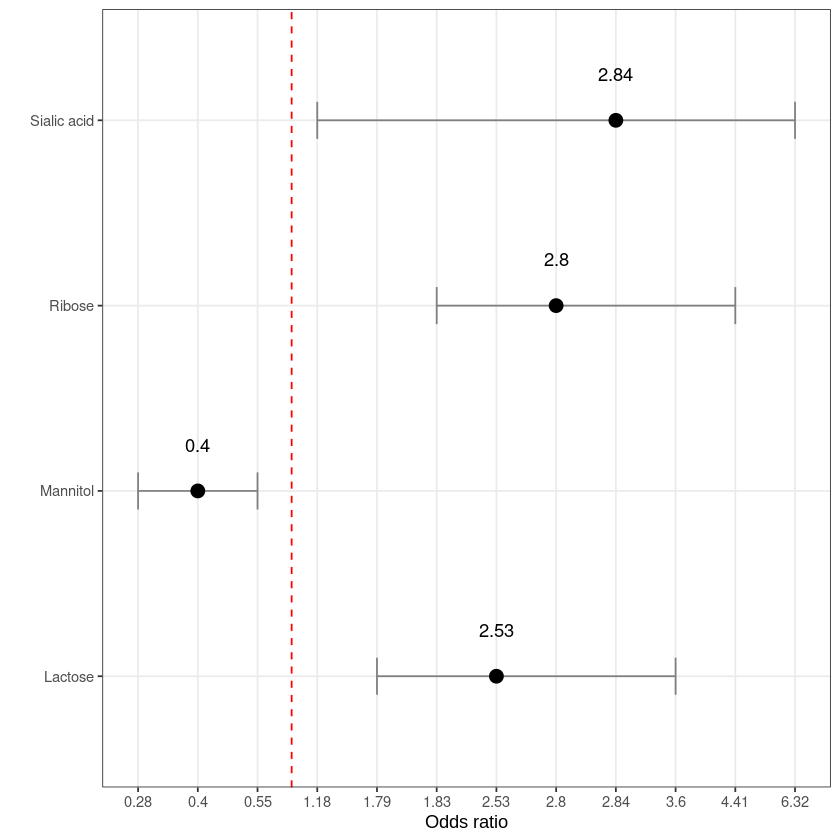

In [13]:
## Calculate odds-ratio - method: median-unbiased estimate & mid-p exact CI 
install.packages("epitools")
library(epitools)
library(dplyr)

### Split the dataframe by Sugar
split_dfs <- split(grouped_df, grouped_df$Sugar)

### Create individual dataframes for each sugar type
for(sugar in names(split_dfs)) {
  assign(paste0(sugar, "_df"), split_dfs[[sugar]])
}

### Calculate median Transporter_Count for each sugar type and category (MRSA and MSSA)
median_transporters <- grouped_df %>%
  group_by(Sugar, Category) %>%
  summarize(Median_Transporter_Count = median(Transporter_Count, na.rm = TRUE))

print(median_transporters)
write.table(median_transporters, file = "median_transportersBYsugar_category.tsv", sep = "\t", row.names = TRUE, col.names = TRUE)

### Creating my matrix 
# mannitol
copy_number <- c('Genomes > Median', 'Genomes < Median')
resistance <- c('MRSA', 'MSSA')
OR_mannitol <- matrix(c(164, 421, 98, 100), nrow=2, ncol=2, byrow=TRUE)
dimnames(OR_mannitol) <- list('Copy Number'=copy_number, 'Resistance Category'=resistance)

OR_mannitol_out <- oddsratio(OR_mannitol) 
OR_mannitol_out

# ribose
OR_ribose <- matrix(c(267, 431, 28, 127), nrow=2, ncol=2, byrow=TRUE)
dimnames(OR_ribose) <- list('Copy Number'=copy_number, 'Resistance Category'=resistance)

OR_ribose_out <- oddsratio(OR_ribose) # odds ratio with 95% C.I. 3.80132 (2.499973 - 5.955532) / midp.exact 4.052003e-11
OR_ribose_out

# sialic acid 
OR_sia <- matrix(c(334, 28, 38, 9), nrow=2, ncol=2, byrow=TRUE)
dimnames(OR_sia) <- list('Copy Number'=copy_number, 'Resistance Category'=resistance)

OR_sia_out <- oddsratio(OR_sia) # odds ratio with 95% C.I. 3.80132 (2.499973 - 5.955532) / midp.exact 4.052003e-11
OR_sia_out

# lactose 
OR_lactose <- matrix(c(427, 317, 59, 111), nrow=2, ncol=2, byrow=TRUE)
dimnames(OR_lactose) <- list('Copy Number'=copy_number, 'Resistance Category'=resistance)

OR_lactose_out <- oddsratio(OR_lactose) # odds ratio with 95% C.I. 3.80132 (2.499973 - 5.955532) / midp.exact 4.052003e-11
OR_lactose_out

## Forest plot - odds ratio 
transporter <- c('Lactose', 'Mannitol', 'Ribose', 'Sialic_acid')
col_names <- c('Transporters', 'Odds_Ratio', 'CI_Low', 'CI_High', 'midp_exact')
OR_plot <- matrix(c('Lactose', 2.53, 1.79, 3.60, 8.947808e-08, 'Mannitol', 0.40, 0.28, 0.55, 5.911416e-08, 'Ribose', 2.80, 1.83, 4.41, 7.157708e-07, 'Sialic acid', 2.84, 1.18, 6.32, 0.0214517), nrow=4, ncol=5, byrow=TRUE)
dimnames(OR_plot) <- list('Sia Transporters'=transporter, 'Column Names'=col_names)

write.table(OR_plot, file = "OR_sugar_transporters.tsv", sep = "\t", row.names = FALSE, col.names = TRUE)

OR_plot <- as.data.frame(OR_plot)

ggplot(OR_plot, aes(x = Odds_Ratio, y = Transporters)) +
    geom_errorbarh(aes(xmax = CI_High, xmin = CI_Low), size = 0.5, height = 0.2, color = 'gray50') +
    geom_point(size = 3.5) +
    theme_bw() +
     theme(panel.grid.minor = element_blank(),
          legend.position = c("top"),
          axis.title.x = element_text(family = "Arial"),
          axis.title.y = element_text(family = "Arial")) +  # Set axis labels to Arial
   ylab('') +
    xlab('Odds ratio') +
    #ggtitle('Odds Ratio for Sia Transporters') +
    geom_text(aes(label = Odds_Ratio), nudge_y = 0.25) +  # Add odds ratio values
    geom_vline(xintercept = 3.571429, linetype = "dashed", color = "red") 
